# Yelp Reviews Sentiment Classification using LSTM

In this notebook, we'll train a LSTM model to classify the Yelp reviews into positive or negative.

In [1]:
# Import Dependencies
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt

In [2]:
tf.__version__

'2.1.0'

# Load Dataset

Here, we'll be usin the ***Yelp Polarity Reviews*** dataset. This is a binary classification dataset that classifies the reviews into positive or negative based on the following criteria:

1. If the rating of the review is "1" or "2", then it is considered to be a negative review.
2. If the rating of the review is "3" or "4", then it is considered to be a positive review.

In [3]:
# Load Yelp Reviews Dataset
# Ref. https://www.tensorflow.org/datasets/catalog/yelp_polarity_reviews
(train_data, test_data), info = tfds.load(name='yelp_polarity_reviews/subwords8k',
                                          split=(tfds.Split.TRAIN, tfds.Split.TEST),
                                          with_info=True,
                                          as_supervised=True)

In [4]:
# Check Dataset Downloaded Files
!ls /Users/anujdutt/tensorflow_datasets/yelp_polarity_reviews/subwords8k/0.1.0

dataset_info.json
label.labels.txt
text.text.subwords
yelp_polarity_reviews-test.tfrecord-00000-of-00001
yelp_polarity_reviews-train.tfrecord-00000-of-00002
yelp_polarity_reviews-train.tfrecord-00001-of-00002


# Inspect the Downloaded Dataset

In [5]:
info

tfds.core.DatasetInfo(
    name='yelp_polarity_reviews',
    version=0.1.0,
    description='Large Yelp Review Dataset.
This is a dataset for binary sentiment classification. We provide a set of 560,000 highly polar yelp reviews for training, and 38,000 for testing. 
ORIGIN
The Yelp reviews dataset consists of reviews from Yelp. It is extracted
from the Yelp Dataset Challenge 2015 data. For more information, please
refer to http://www.yelp.com/dataset_challenge

The Yelp reviews polarity dataset is constructed by
Xiang Zhang (xiang.zhang@nyu.edu) from the above dataset.
It is first used as a text classification benchmark in the following paper:
Xiang Zhang, Junbo Zhao, Yann LeCun. Character-level Convolutional Networks
for Text Classification. Advances in Neural Information Processing Systems 28
(NIPS 2015).


DESCRIPTION

The Yelp reviews polarity dataset is constructed by considering stars 1 and 2
negative, and 3 and 4 positive. For each polarity 280,000 training samples and
19,000 t

In [6]:
# Get the Features
info.features

FeaturesDict({
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=2),
    'text': Text(shape=(None,), dtype=tf.int64, encoder=<SubwordTextEncoder vocab_size=8176>),
})

In [7]:
# Get Size of Training and Test Data Samples
info.splits

{'test': <tfds.core.SplitInfo num_examples=38000>,
 'train': <tfds.core.SplitInfo num_examples=560000>}

# Playing with Vocabulary Encoder and Decoder

In [8]:
# Check top 20 words in vocabulary
# Ref. https://www.tensorflow.org/datasets/api_docs/python/tfds/features/text/SubwordTextEncoder
encoder = info.features['text'].encoder
encoder.subwords[:20]

['the_',
 ', ',
 'and_',
 '. ',
 'I_',
 'a_',
 'to_',
 'was_',
 'of_',
 '.  ',
 's_',
 'in_',
 'is_',
 'for_',
 'it_',
 'that_',
 't_',
 'my_',
 'with_',
 'on_']

In [9]:
# Test the Encoder
sample_text = "That restaurant offers great food, must try out."

# Encode the text and print out their index in Vocabulary
ids = encoder.encode(sample_text)
ids

[589, 180, 2907, 91, 119, 2, 518, 167, 191, 7966]

In [10]:
# Get the words from Index in Vocabulary
text = encoder.decode(ids)
text

'That restaurant offers great food, must try out.'

In [11]:
# Vocabulary Size
encoder.vocab_size

8176

# Training and Validation Data Creation

In [12]:
# Define Data Buffer Size and Batch Size
Buffer_Size = 1000
Batch = 64

In [13]:
# Load Data in Batches
# Here we set the buffer size to 1000 i.e. at a time we randomly pick up 1000 reviews and fill the buffer with that.
# Then we pick up "N" number of padded samples defined by "padded_batch(batch_size= N)"
# Using "padded_shape = ([None], [])" Pads the data to the smallest per-batch size that fits all elements. 
# Since, the shape of Input is: 'text': Text(shape=(None,), so padded_shape = ([None],[])
# Ref. https://www.tensorflow.org/api_docs/python/tf/data/Dataset#padded_batch
train_batches = train_data.shuffle(Buffer_Size).padded_batch(batch_size= Batch, padded_shapes= ([None],[]))
test_batches = test_data.shuffle(Buffer_Size).padded_batch(batch_size= Batch, padded_shapes= ([None],[]))

# Model Definition

In [14]:
# Embedding Dimension
embedding_dim = 64

# Create the Model Architecture
# Ref. https://www.tensorflow.org/api_docs/python/tf/keras/layers/Bidirectional
model = tf.keras.Sequential([# Word Embeddings Layer, embeddings learnt as part of model training process
                           tf.keras.layers.Embedding(encoder.vocab_size, embedding_dim),
                           # Bi-directional LSTM
                           tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(units= 64)),
                           # Dense Layer
                           tf.keras.layers.Dense(units= 64, activation='relu'),
                           # Output Layer: Binary Output
                           tf.keras.layers.Dense(units= 1)
])

# Print Model Summary
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 64)          523264    
_________________________________________________________________
bidirectional (Bidirectional (None, 128)               66048     
_________________________________________________________________
dense (Dense)                (None, 64)                8256      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 65        
Total params: 597,633
Trainable params: 597,633
Non-trainable params: 0
_________________________________________________________________


In [15]:
# Compile the Model
# Ref. https://www.tensorflow.org/api_docs/python/tf/keras/losses/BinaryCrossentropy
model.compile(optimizer= tf.keras.optimizers.Adam(learning_rate= 1e-4),
              # Use BinaryCrossEntropy Loss here as model only has two label classes
              # As per our model definition, there will be a single floating-point value per prediction
              loss= tf.keras.losses.BinaryCrossentropy(from_logits= True),
              metrics= ['accuracy'])

# Model Training & Saving

In [16]:
# Epochs
Epochs = 5

# Validation StepsLeo
Valid_Steps = 10

# Train the Model
hist = model.fit(train_batches,
                 epochs= Epochs,
                 validation_data= test_batches,
                 validation_steps= Valid_Steps,
                 workers=4)

Epoch 1/5
8750/8750 [==============================] - 4812s 550ms/step - loss: 0.2254 - accuracy: 0.9027 - val_loss: 0.1662 - val_accuracy: 0.9469
Epoch 2/5
8750/8750 [==============================] - 5007s 572ms/step - loss: 0.1737 - accuracy: 0.9328 - val_loss: 0.1972 - val_accuracy: 0.9297
Epoch 3/5
8750/8750 [==============================] - 5127s 586ms/step - loss: 0.1608 - accuracy: 0.9374 - val_loss: 0.1214 - val_accuracy: 0.9672
Epoch 4/5
8750/8750 [==============================] - 4555s 521ms/step - loss: 0.1480 - accuracy: 0.9421 - val_loss: 0.1165 - val_accuracy: 0.9563
Epoch 5/5
8750/8750 [==============================] - 4544s 519ms/step - loss: 0.1291 - accuracy: 0.9498 - val_loss: 0.1013 - val_accuracy: 0.9516


In [17]:
# Get all Keys for History
hist.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [18]:
# Save Trained Model
model.save('reviews_polarity_single_lstm.h5')
model.save_weights('reviews_polarity_single_lstm_weights.h5')

# Trained Model Performance Evaluation

In [19]:
# Get the Validation Loss and Validation Accuracy
test_loss, test_acc = model.evaluate(test_batches)

print('Test Loss: {}'.format(test_loss))
print('Test Accuracy: {}'.format(test_acc))

    594/Unknown - 61s 103ms/step - loss: 0.1364 - accuracy: 0.9451Test Loss: 0.13639571661010436
Test Accuracy: 0.9451315999031067


In [20]:
# Get the Trained Model Metrics
history_dict = hist.history

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss=history_dict['loss']
val_loss=history_dict['val_loss']

epochs = range(1, len(acc) + 1)

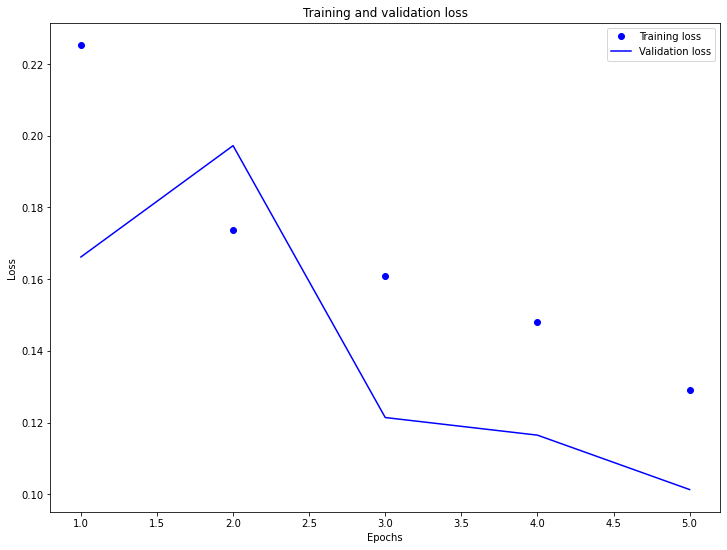

In [24]:
# Plot Training and Validation Loss
plt.figure(figsize=(12,9))
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

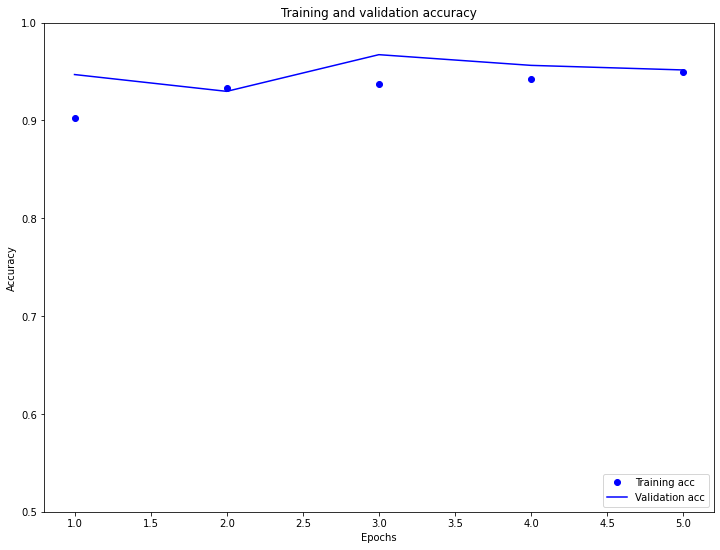

In [25]:
# Plot Training and Validation Accuracy
plt.figure(figsize=(12,9))
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.ylim((0.5,1))
plt.show()

## Model Evaluation

The above model does not mask the padding applied to the sequences. This can lead to skew if trained on padded sequences and test on un-padded sequences. Ideally we would use masking to avoid this, but as you can see below it only have a small effect on the output.

If the prediction is >= 0.5, it is positive else it is negative.

In [26]:
# Function to Zero Pad Input Reviews
def pad_to_size(vec, size):
    zeros = [0] * (size - len(vec))
    vec.extend(zeros)
    return vec

In [27]:
# Function to make predictions on Input Reviews
def sample_predict(sample_pred_text, pad):
    encoded_sample_pred_text = encoder.encode(sample_pred_text)
    
    if pad:
        encoded_sample_pred_text = pad_to_size(encoded_sample_pred_text, 64)
    encoded_sample_pred_text = tf.cast(encoded_sample_pred_text, tf.float32)
    predictions = model.predict(tf.expand_dims(encoded_sample_pred_text, 0))

    return (predictions)

In [31]:
# Positive Review without Zero Padding
sample_pred_text = ('That restaurant offers great food, must try out.')

predictions = sample_predict(sample_pred_text, pad=False)
print(predictions)

[[0.61917293]]


In [32]:
# Positive Review with Zero Padding
sample_pred_text = ('That restaurant offers great food, must try out.')

predictions = sample_predict(sample_pred_text, pad=True)
print(predictions)

[[1.2357517]]


In [34]:
# Negative Review without Zero Padding
sample_pred_text = ('The food at that restaurant was the worst ever. I would not recommend it to anyone.')

predictions = sample_predict(sample_pred_text, pad=False)
print(predictions)

[[-4.628654]]


In [33]:
# Negative Review with Zero Padding
sample_pred_text = ('The food at that restaurant was the worst ever. I would not recommend it to anyone.')

predictions = sample_predict(sample_pred_text, pad=True)
print(predictions)

[[-6.386962]]
